In [37]:
%matplotlib inline

import warnings
import os
from datetime import datetime
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice
np.random.seed(42)

In [3]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.1f}'

## Prepare Data

### Get source

In [4]:
def get_data(start='2000', end='2018', holding_period=1, dropna=True):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore('data.h5') as store:
        df = store['data']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

In [5]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

In [6]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

### One-Hot Encoding

In [7]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

In [8]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

In [9]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

## Cross-Validation Setup

### Custom Time Series KFold Generator

In [14]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X
                        .index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [15]:
n_splits = 10
cv = OneStepTimeSeriesSplit(n_splits=n_splits)

### CV Metrics

In [16]:
metrics = {'accuracy': 'balanced_accuracy',
           'precision': 'precision_weighted',
           'recall': 'recall_weighted',
           'f1': 'f1_weighted',
           'neg_log_loss': 'neg_log_loss',
           'auc': 'roc_auc'
}

In [17]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None):
    return cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=metrics,
                          cv=cv,
                          return_train_score=True,
                          n_jobs=-1,
                          verbose=1,
                          fit_params=fit_params)

### CV Result Handler Functions

In [18]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: ' '.join([m.capitalize() for m in x.split('_')]))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [19]:
def plot_result(df, model=None):
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    fig = g.fig
    fig.suptitle(model, fontsize=18)
    fig.subplots_adjust(top=.9);

## RandomForest

### Configure

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100,             # will change from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [ ]:
rf_cv_result = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)

### Plot Results

In [ ]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

In [ ]:
plot_result(rf_result, model='Random Forest')

## sklearn: GradientBoostingClassifier

### Configure

In [ ]:
gb_clf = GradientBoostingClassifier(loss='deviance',                # deviance = logistic reg; exponential: AdaBoost
                                    learning_rate=0.1,              # shrinks the contribution of each tree
                                    n_estimators=100,               # number of boosting stages
                                    subsample=1.0,                  # fraction of samples used t fit base learners
                                    criterion='friedman_mse',       # measures the quality of a split
                                    min_samples_split=2,            
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,   # min. fraction of sum of weights
                                    max_depth=3,                    # opt value depends on interaction
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features=None, 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='auto', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001)

### Cross-validate

In [ ]:
gb_cv_result = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)

### Plot Results

In [ ]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

In [ ]:
plot_result(gb_result, model='Gradient Boosting Classifier')

## XGBoost

### Configure Baseline Parameters

In [29]:
xgb_params = dict(
    objective='binary:logistic',
    eval_metric=['logloss', 'auc'],
    tree_method='gpu_hist',
    eta=0.3,
    gamma=0,
    max_depth=6,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    alpha=0,
    n_jobs=-1,
    silent=1,
    seed=42)
xgb_params['lambda'] = 1  # reserved keyword

cv_sets = ['train', 'eval']
num_boost_rounds = 250
early_stopping = 25

### Adaptive Learning Rate Callback

In [31]:
def adaptive_learning_rate(n, ntot=num_boost_rounds):
    start_eta = 0.1
    k = 8 / ntot
    x0 = ntot / 1.8
    return start_eta * (1 - 1 / (1 + np.exp(-k * (n - x0))))

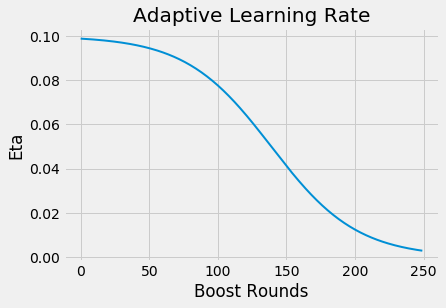

In [35]:
ntot = num_boost_rounds
n = np.arange(num_boost_rounds)
pd.Series(adaptive_learning_rate(n=n, ntot=ntot)).plot(title='Adaptive Learning Rate', lw=2)
plt.xlabel('Boost Rounds')
plt.ylabel('Eta');

### Create custom data format

In [ ]:
xgb_datasets = {}
for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    xgb_datasets[fold] = {'train': xgb.DMatrix(label=y.iloc[train_idx], data=X.iloc[train_idx], nthread=-1),
                      'eval' : xgb.DMatrix(label=y.iloc[test_idx], data=X.iloc[test_idx], nthread=-1)}

In [ ]:
xgb_results = ['learning_curve', 'feature_importance', 'cv_result']
xgb_cv_results = {result: pd.DataFrame() for result in xgb_results}
xgb_models = pd.DataFrame()

### Cross-Validation

In [ ]:
def run_cv(test_params, data, n_splits=10):
    """Train-Validate with early stopping"""
    df = {r: pd.DataFrame() for r in xgb_results}

    for fold in range(n_splits):
        dtrain = data[fold]['train']
        dtest = data[fold]['eval']

        watchlist = list(zip([dtrain, dtest], cv_sets))
        scores = {}

        model = xgb.train(params=test_params,
                          dtrain=dtrain,
                          num_boost_round=num_boost_rounds,
                          verbose_eval=50,
                          evals=watchlist,
                          early_stopping_rounds=early_stopping,
                          evals_result=scores,
                          callbacks=[reset_learning_rate(learning_rate)])

        df['cv_result'] = pd.concat([df['cv_result'],
                                     pd.DataFrame({
                                         'predictions': model.predict(dtest),
                                         'actuals'    : dtest.get_label(),
                                     }).assign(fold=fold)])

        df['learning_curve'] = pd.concat([df['learning_curve'],
                                          (pd.concat([pd.DataFrame(scores[s]) for s in cv_sets],
                                                     axis=1,
                                                     keys=cv_sets)
                                           .assign(fold=fold))])

        df['feature_importance'] = (pd.concat([df['feature_importance'],
                                               pd.Series(model.get_score(importance_type='gain'))
                                              .to_frame('fi')
                                              .assign(fold=fold)]))
    return df


### Parameter Grid

In [ ]:
boosters = ['gbtree', 'dart']
tree_methods = ['gpu_exact', 'gpu_hist']
max_depths = [3, 5, 7, 9, 11, 13, 15]
etas = [.01, .1]
gammas = [0, 1, 5]
colsample_bytrees = [.5, .7, 1]
n_models = len(boosters) * len(tree_methods) * len(max_depths) * len(etas) * len(colsample_bytrees)

### Run grid search

In [ ]:
start = time()
n = 0
for booster in boosters:
    for tree_method in tree_methods:
        for max_depth in max_depths:
            for eta in etas:
                for gamma in gammas:
                    for colsample_bytree in colsample_bytrees:
                        iteration = time()
                        cv_params = xgb_params.copy()
                        train_params = dict(max_depth=max_depth,
                                            eta=eta,
                                            gamma=gamma,
                                            colsample_bytree=colsample_bytree,
                                            tree_method=tree_method,
                                            booster=booster)
                        cv_params.update(train_params)

                        cv_result = run_cv(test_params=cv_params,
                                           data=xgb_datasets,
                                           n_splits=n_splits)

                        for result, data in cv_result.items():
                            xgb_cv_results[result] = pd.concat([cv_results[result],
                                                                data.assign(model=n)])

                        out = f'\n\tModel: {n} of {n_models} | '
                        out += f'Iteration: {format_time(time() - iteration)} | '
                        print(out + f'Total: {format_time(time() - start)}\n')

                        cv_params['time'] = time() - iteration
                        xgb_models[n] = pd.Series(cv_params)
                        n += 1

### Capture Results

In [ ]:
xgb_cv_results['learning_curve'].columns = pd.MultiIndex.from_tuples(xgb_cv_results['learning_curve'].columns)
with pd.HDFStore('model_tuning.h5') as store:
    for result, data in xgb_cv_results.items():
        store.put(f'xgboost/{result}', data)
    store.put('xgboost/models', xgb_models)

## LightGBM

### Configure Baseline Parameters

In [20]:
lgb_params = dict(boosting='gbdt',
                  objective='binary',
                  task='train',
                  max_bin=63,                # default: 255; lower => speedup
                  metric='auc',
                  eta=0.1,                   # learning rate
                  n_estimators=100,
                  max_depth=5,
                  num_leaves=31,             # max no of leaves per tree
                  colsample_bytree=0.8,      # subsample features; default = 1.0
                  bagging_fraction=1.0,      # subsample rows (no replacement)
                  bagging_freq=5,
                  subsample_for_bin=200000,
                  min_split_gain=0.0,        # min gain for split (~gamma xgboost)
                  min_child_weight=0.001,    # min sum hessian in leaf
                  min_data_in_leaf=20,
                  reg_alpha=0.0,
                  reg_lambda=0.0,
                  is_unbalance=False,
                  device='gpu',
                  n_jobs=-1,
                  verbose=1,                 # level: info (vs debug(>1)/error(=0))
                  random_state=42)

### Create custom data format

In [23]:
lgb_datasets = {}
for fold, (train_idx, test_idx) in enumerate(cv.split(X_factors)):
    train = lgb.Dataset(label=y.iloc[train_idx],
                        data=X_factors.iloc[train_idx],
                        categorical_feature=cat_cols)

    # align validation set histograms with training set
    valid = train.create_valid(label=y.iloc[test_idx],
                               data=X_factors.iloc[test_idx])

    lgb_datasets[fold] = {'train': train,
                          'eval': valid,
                          'predict': X_factors.iloc[test_idx]}

In [36]:
lgb_results = ['feature_importance', 'cv_result']
lgb_cv_results = {result: pd.DataFrame() for result in lgb_results}
lgb_models = pd.DataFrame()

### Cross-Validation

In [34]:
def run_cv(test_params, data, num_boost_rounds=num_boost_rounds, early_stopping=early_stopping, n_splits=10):
    """Train-Validate with early stopping"""
    df = {r: pd.DataFrame() for r in lgb_results}

    for fold in range(n_splits):
        lgb_train = data[fold]['train']
        lgb_test = data[fold]['eval']
        X_test = data[fold]['predict']
        scores = {}

        model = lgb.train(params=test_params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_rounds,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train', 'eval'],
                          verbose_eval=50,
                          early_stopping_rounds=early_stopping,
                          evals_result=scores)

        df['cv_result'] = pd.concat([df['cv_result'],
                                     pd.DataFrame({
                                         'predictions': model.predict(X_test),
                                         'actuals'    : lgb_test.get_label(),
                                     }).assign(fold=fold)])

        df['feature_importance'] = (pd.concat([df['feature_importance'],
                                               pd.Series(model.feature_importance(importance_type='gain'))
                                              .to_frame('fi')
                                              .assign(fold=fold)]))
    return df


### Parameter Grid

In [25]:
boostings = ['gbdt', 'dart', 'rf']
max_depths = [-1, 7, 12]
num_leavess = [2**i for i in [3, 4, 5, 6, 7]]
etas = [.01, .1]
min_data_in_leaves = [20, 100, 500]
n_models = len(boosting) * len(max_depths) * len(num_leavess)* len(etas) * len(min_data_in_leaf)

### Run grid search

In [ ]:
start = time()
n = 0
for boosting in boostings:
    for max_depth in max_depths:
        for num_leaves in num_leavess:
            for eta in etas:
                for min_data_in_leaf in min_data_in_leaves:
                    iteration = time()
                    cv_params = lgb_params.copy()
                    train_params = dict(boosting=boosting,
                                        max_depth=max_depth,
                                        num_leaves=num_leaves,
                                        eta=eta,
                                        min_data_in_leaf=min_data_in_leaf)
                    cv_params.update(train_params)

                    cv_result = run_cv(test_params=cv_params,
                                       data=lgb_datasets,
                                       n_splits=n_splits)

                    for result, data in cv_result.items():
                        lgb_cv_results[result] = pd.concat([lgb_cv_results[result],
                                                            data.assign(model=n)])

                    out = f'\n\tModel: {n} of {n_models} | '
                    out += f'Iteration: {format_time(time() - iteration)} | '
                    print(out + f'Total: {format_time(time() - start)}\n')

                    cv_params['time'] = time() - iteration
                    lgb_models[n] = pd.Series(cv_params)
                    n += 1

### Capture Results

In [ ]:
with pd.HDFStore('model_tuning.h5') as store:
    for result, data in lgb_cv_results.items():
        store.put(f'lgboost/{result}', data)
    store.put('lgboost/models', lgb_models)

## Catboost

### Configure

In [ ]:
cat_params = dict(iterations=500,
                  learning_rate=0.03,
                  depth=6,
                  l2_leaf_reg=3,
                  model_size_reg=None,
                  rsm=None,                             # Subsample ratio of columns
                  loss_function='Logloss',
                  border_count=32,                      # number of partitions for Num feature
                  # Type of binarization target (for regression)
                  feature_border_type='MinEntropy',
                  od_pval=None,                         # overfitting detector to stop training
                  od_wait=None,                         # No iterations od will wait
                  od_type=None,                         # Type of overfitting detector
                  # treat missing values as min [max, forbidden]
                  nan_mode='Min',
                  counter_calc_method=None,             #
                  leaf_estimation_iterations=1,
                  leaf_estimation_method='Gradient',
                  thread_count=None,                    # None: no of cores
                  random_seed=None,
                  use_best_model=None,
                  best_model_min_trees=None,
                  verbose=100,
                  logging_level='Verbose',
                  metric_period=1,
                  simple_ctr=None,                      # Binarization settings for categorical features
                  ctr_leaf_count_limit=None,
                  store_all_simple_ctr=None,
                  max_ctr_complexity=1,
                  has_time=None,
                  allow_const_label=None,
                  classes_count=None,
                  class_weights=None,
                  one_hot_max_size=None,                # Convert the feature to float
                  random_strength=None,
                  name=None,
                  ignored_features=None,
                  train_dir=None,
                  custom_loss=None,
                  custom_metric=None,
                  eval_metric='AUC',
                  bagging_temperature=None,
                  save_snapshot=None,
                  snapshot_file=None,
                  snapshot_interval=None,
                  fold_len_multiplier=None,
                  used_ram_limit=None,
                  gpu_ram_part=.2,
                  pinned_memory_size=None,
                  allow_writing_files=None,
                  final_ctr_computation_mode=None,
                  approx_on_full_history=None,
                  boosting_type=None,
                  combinations_ctr=None,
                  per_feature_ctr=None,
                  ctr_description=None,
                  task_type='GPU',
                  bootstrap_type='Bayesian',
                  subsample=None,
                  dev_score_calc_obj_block_size=None,
                  gpu_cat_features_storage=None,
                  data_partition=None,
                  metadata=None,
                  early_stopping_rounds=None)

### Custom data format

In [39]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [40]:
cat_datasets = {}
for fold, (train_idx, test_idx) in enumerate(cv.split(X_factors)):
    train = Pool(label=y.iloc[train_idx],
                 data=X_factors.iloc[train_idx],
                 cat_features=cat_cols_idx)

    valid = Pool(label=y.iloc[test_idx],
                 data=X_factors.iloc[test_idx],
                 cat_features=cat_cols_idx)

    cat_datasets[fold] = {'train': train,
                          'eval': valid}

In [41]:
cat_results = ['feature_importance', 'cv_result']
cat_cv_results = {result: pd.DataFrame() for result in cat_results}
cat_models = pd.DataFrame()

### Cross-Validate

In [ ]:
def run_cv(test_params, data, num_boost_rounds=num_boost_rounds, early_stopping=early_stopping, n_splits=10):
    """Train-Validate with early stopping"""
    df = {r: pd.DataFrame() for r in cat_results}
    model = CatBoostClassifier(**test_params)

    for fold in range(n_splits):
        cat_train = data[fold]['train']
        cat_test = data[fold]['eval']

        scores = {}

        model = model.fit(X=cat_train,
                          num_boost_round=num_boost_rounds,
                          eval_set=[cat_train, cat_test],
                          valid_names=['train', 'eval'],
                          logging_level='Info',
                          early_stopping_rounds=early_stopping)

        df['cv_result'] = pd.concat([df['cv_result'],
                                     pd.DataFrame({
                                         'predictions': model.predict_proba(cat_test),
                                         'actuals': cat_test.get_label(),
                                     }).assign(fold=fold)])
feature_importances = model.get_feature_importance(train_pool)
        df['feature_importance'] = (pd.concat([df['feature_importance'],
                                               pd.Series(model..get_feature_importance(cat_train, importance_type='gain'))
                                               .to_frame('fi')
                                               .assign(fold=fold)]))
    return df

### Plot Results

In [ ]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

In [ ]:
plot_result(cat_result, model='CatBoost')

In [ ]:
results = {'Baseline': dummy_result,
          'Random Forest': rf_result,
          'AdaBoost': ada_result,
          'Gradient Booster': gb_result,
          'XG Boost': xbg_result,
          'LightGBM': lgb_result,
          'CatBoost': cat_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T